* For this assignment, you will be predicting energy consumption for the next 24 months. You will ultimately be comparing a seasonal and nonseasonal model.

In [142]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [143]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [144]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [145]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):
    

    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)
        
    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)
        
    else: 
        raise Exception("type must be either 'ACF' or 'PACF'")
        
    # Determine lags
    lags =range(len(corr_values))
    
    # Create a centered version of the acf_df 
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")
    
    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s 
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags



In [146]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

# FUNC  &  IMPORT 

In [147]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs
# set random seed
SEED = 321
np.random.seed(SEED)
sns.set_context('notebook', font_scale=1.2)
plt.rcParams['figure.figsize']=(12,3)

In [148]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

In [149]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)
    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)
    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")
    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)
    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax


In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100
    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")
    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics


In [151]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [152]:
def get_sig_lags(ts, type='ACF',  nlags=None,alpha=0.5):
    

    if type == 'ACF':
        # Running the function used by plot_acf
        corr_values, conf_int = tsa.stattools.acf(ts, alpha=alpha, nlags=nlags)
        
    elif type=='PACF':
        corr_values, conf_int = tsa.stattools.pacf(ts, alpha=alpha, nlags=nlags)
        
    else: 
        raise Exception("type must be either 'ACF' or 'PACF'")
        
    # Determine lags
    lags =range(len(corr_values))
    
    # Create a centered version of the acf_df 
    corr_df = pd.DataFrame({type:corr_values,
                            'Lags':lags,
                            'lower ci': conf_int[:,0]-corr_values, # subtract acf from lower ci to center
                            'upper ci': conf_int[:,1]-corr_values, # subtact acf to upper ci to center
                                 })
    corr_df = corr_df.set_index("Lags")
    
    # Getting filter for sig lags
    filter_sig_lags = (corr_df[type] < corr_df['lower ci']) | (corr_df[type] > corr_df['upper ci'])

    # Get lag #'s 
    sig_lags= corr_df.index[filter_sig_lags]
    sig_lags = sig_lags[sig_lags!=0]

    return sig_lags

# LOAD DATA 

In [153]:
df  = pd.read_csv('opsd_germany_daily.csv') 
df.head()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
 2   Wind         2920 non-null   float64
 3   Solar        2188 non-null   float64
 4   Wind+Solar   2187 non-null   float64
dtypes: float64(4), object(1)
memory usage: 171.3+ KB


,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [154]:
# drop  columns  
df=  df.drop(columns= ['Wind','Solar','Wind+Solar'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         4383 non-null   object 
 1   Consumption  4383 non-null   float64
dtypes: float64(1), object(1)
memory usage: 68.6+ KB


In [155]:
df['Date']= pd.to_datetime(df['Date'])
df= df.set_index('Date')


In [156]:
# The data is daily, but we have been asked to resample to Monthly using the mean
df = df.resample('M').mean()

ts = df['Consumption']
ts

Date
2006-01-31    1461.442065
2006-02-28    1467.106893
2006-03-31    1418.649161
2006-04-30    1275.058900
2006-05-31    1253.488484
                 ...     
2017-08-31    1291.283022
2017-09-30    1335.952031
2017-10-31    1366.297385
2017-11-30    1477.990818
2017-12-31    1435.842075
Freq: M, Name: Consumption, Length: 144, dtype: float64

<Axes: xlabel='Date'>

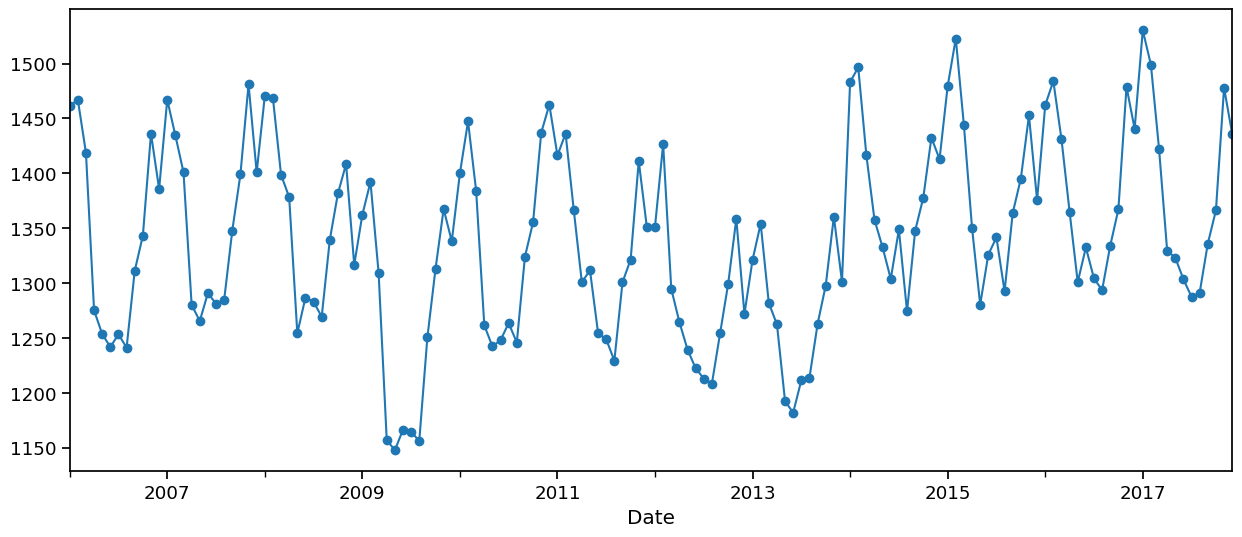

In [157]:
# plot ts  
ts.plot(style = '-o' , label = 'Consumption asfreq month' , figsize = (15,6))

# Seasonality

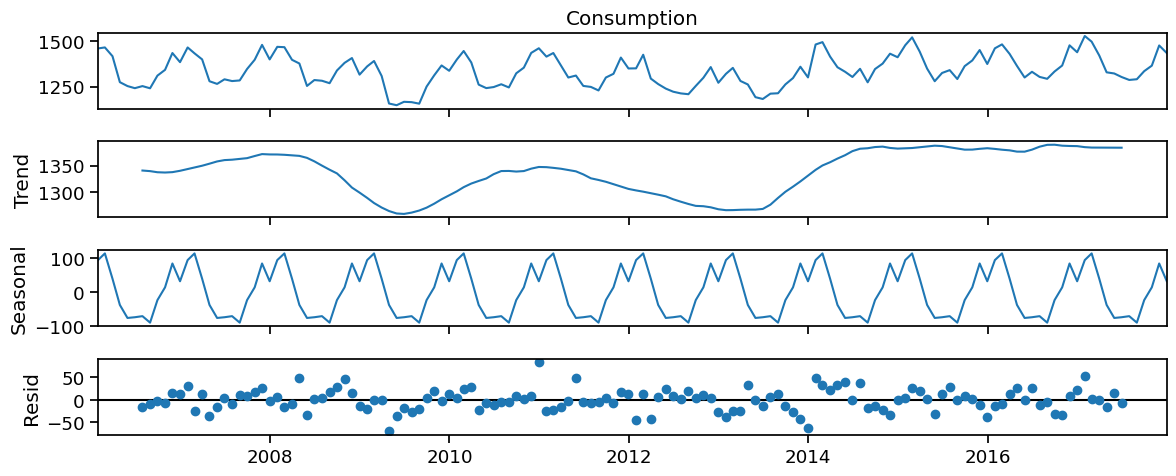

In [158]:
decomp =  tsa.seasonal_decompose(ts)
fig =  decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [159]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta: .2f} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is  202.82 which is ~52.99% of the variation in time series.


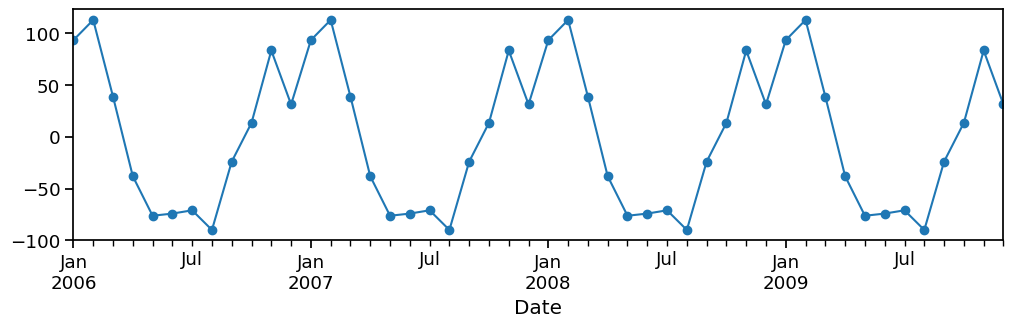

In [160]:
# Narrow down the date range of the plot
seasonal = decomp.seasonal
ax = seasonal.loc['2006': '2009'].plot(marker = 'o')

# ARIMA

In [161]:
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-2.637146,13,130,0.08556,0.05,False


In [162]:
# check for nonseasonal differencing 
# check for seasonal differencing 
d = ndiffs(ts)
print(f'd = {d}')
D = nsdiffs(ts , m=12)
print(f'D = {D}')

d = 0
D = 0


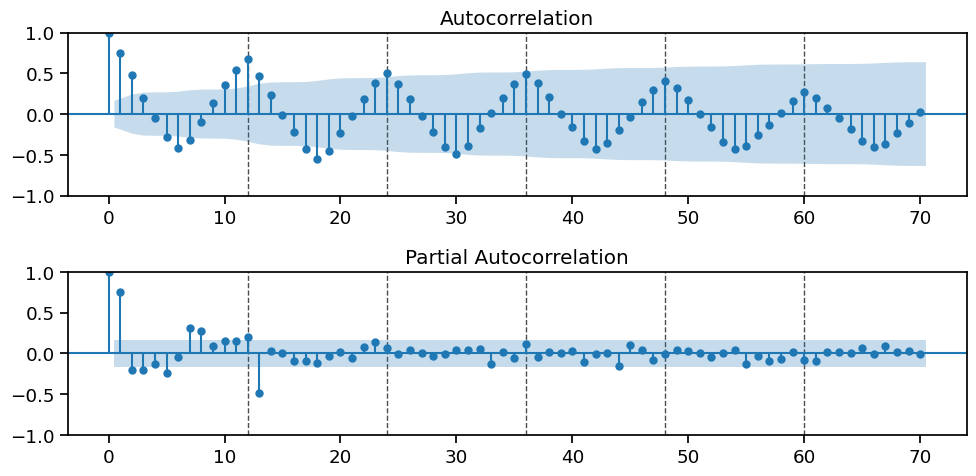

In [163]:
plot =plot_acf_pacf(ts , annotate_seas=True , m = 12 ,nlags= 70)

<Axes: xlabel='Date'>

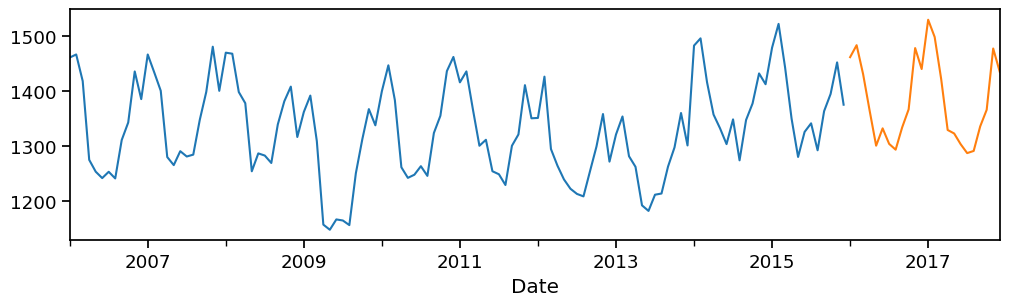

In [164]:
#train_test _splite 
train , test = train_test_split(ts  , test_size=24)
ax  =  train.plot(label = 'train')
test.plot(ax=ax, label = 'test')

In [165]:
p = 1 
d = 0 
q = 1 
arima_model   = tsa.ARIMA(train , order=(p,d,q)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -652.382
Date:                Sun, 09 Jun 2024   AIC                           1312.765
Time:                        15:29:36   BIC                           1323.915
Sample:                    01-31-2006   HQIC                          1317.293
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1333.5727     19.511     68.350      0.000    1295.332    1371.814
ar.L1          0.6850      0.108      6.322      0.000       0.473       0.897
ma.L1          0.1710      0.135      1.269      0.205      -0.093       0.435
sigma2      3064.9828    397.028      7.720      0.000    2286.822    3843.143
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.83   Prob(JB):                         0.81
Heteroskedasticity (H):               0.89   Skew:                             0.13
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

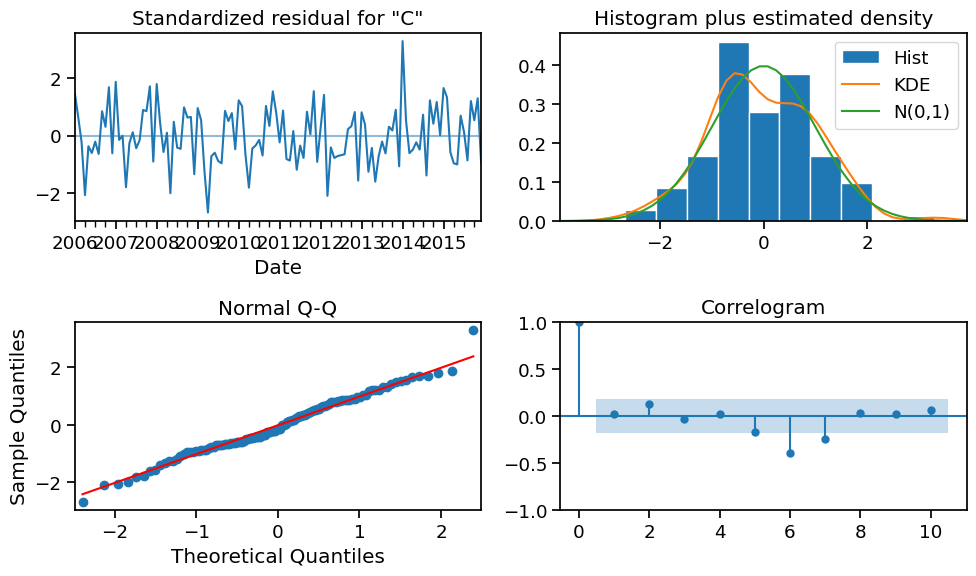

In [166]:
# Obtain diagnostic plots
fig =arima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 67.630
- MSE = 7,817.910
- RMSE = 88.419
- R^2 = -0.349
- MAPE = 4.70%


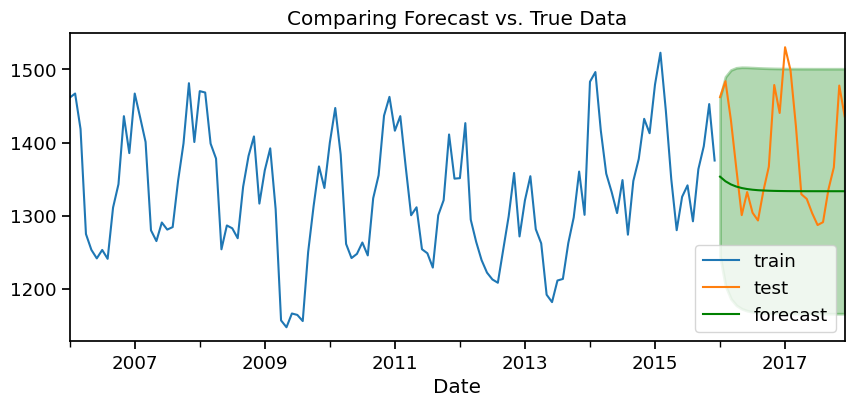

In [167]:
# Obtain forecast as a dataframe with confidence intervals
forecast_arima =  arima_model.get_forecast(steps = len(test)).summary_frame() 
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train , test , forecast_arima)
# Obtain metrics
regression_metrics_ts(test ,forecast_arima['mean'])

# SARIMA 

In [168]:
p = 1 
d = 0 
q = 0
P= 1 
D = 0 
Q = 1 
m = 12 
sarima_model   =  tsa.ARIMA(train , order=(p , d , q ) , seasonal_order=(P,D,Q,m)).fit()
# Obtain summary
sarima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Sun, 09 Jun 2024   AIC                           1215.739
Time:                                    15:29:38   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7441     57.874     22.994      0.000    1217.314    1444.174
ar.L1          0.7880      0.058     13.539      0.000       0.674       0.902
ar.S.L12       0.9953      0.011     91.808      0.000       0.974       1.017
ma.S.L12      -0.8616      0.157     -5.489      0.000      -1.169      -0.554
sigma2      1088.7145    201.459      5.404      0.000     693.863    1483.566
===================================================================================
Ljung-Box (L1) (Q):                   4.24   Jarque-Bera (JB):                23.70
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

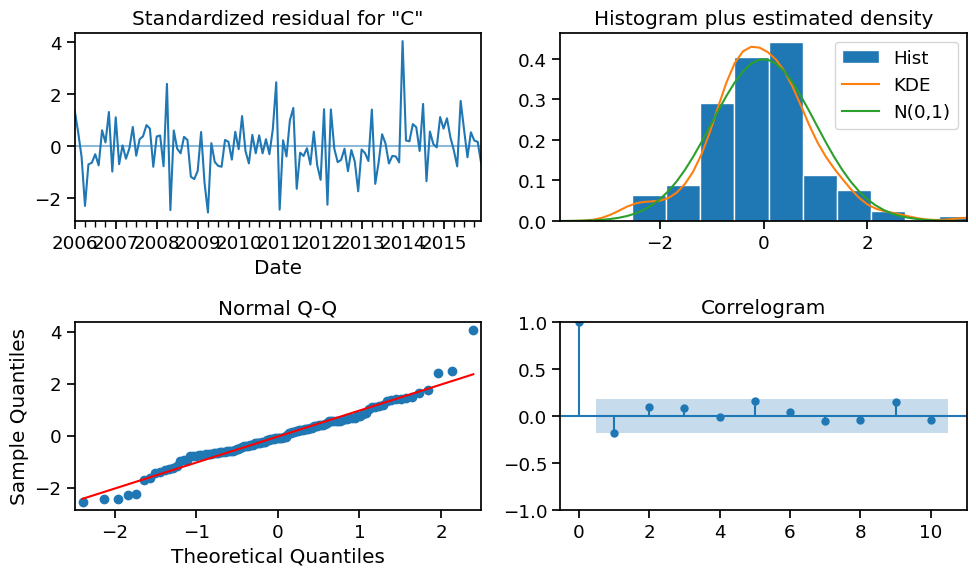

In [169]:
# Obtain diagnostic plots
fig =sarima_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.219
- MSE = 2,686.861
- RMSE = 51.835
- R^2 = 0.536
- MAPE = 3.30%


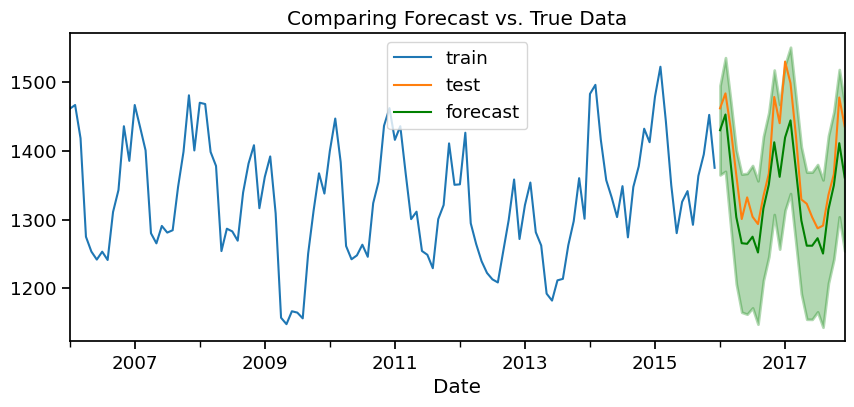

In [170]:
# Obtain forecast as a dataframe with confidence intervals
forecast_sarima =  sarima_model.get_forecast(steps = len(test)).summary_frame() 
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train , test , forecast_sarima)
# Obtain metrics
regression_metrics_ts(test ,forecast_sarima['mean'])

* The seasonal model follows the general seasonal cycles.
* The seasonal model also has lower AIC score and preferred values for regression metrics

# Gridsearch 

In [175]:
import pmdarima as pm 
# Default auto_arima will select model based on AIC score
auto_model = pm.auto_arima(train,seasonal=True ,m=12,
    trace=True  )

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1250.331, Time=0.82 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1411.678, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1264.720, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1303.150, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2069.451, Time=0.02 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1249.058, Time=1.09 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2,0,2)(2,0,0)[12] intercept   : AIC=1250.764, Time=1.12 sec
 ARIMA(2,0,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.31 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=1254.012, Time=0.36 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=1252.495, Time=0.69 sec
 ARIMA(2,0,3)(1,0,0)[12] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1

In [176]:
print(auto_model.order)
print(auto_model.seasonal_order)

(1, 0, 1)
(1, 0, 0, 12)


In [177]:
# Obtain summary of the best model from auto_arima
auto_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 12)   Log Likelihood                -612.171
Date:                             Sun, 09 Jun 2024   AIC                           1234.341
Time:                                     16:00:40   BIC                           1248.279
Sample:                                 01-31-2006   HQIC                          1240.002
                                      - 12-31-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    102.8566     51.013      2.016      0.044       2.874     202.839
ar.L1          0.7420      0.090      8.264      0.000       0.566       0.918
ma.L1         -0.0414      0.140     -0.297      0.767      -0.315       0.232
ar.S.L12       0.6979      0.076      9.190      0.000       0.549       0.847
sigma2      1440.9847    126.763     11.368      0.000    1192.534    1689.435
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.30
Prob(H) (two-sided):                  0.51   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

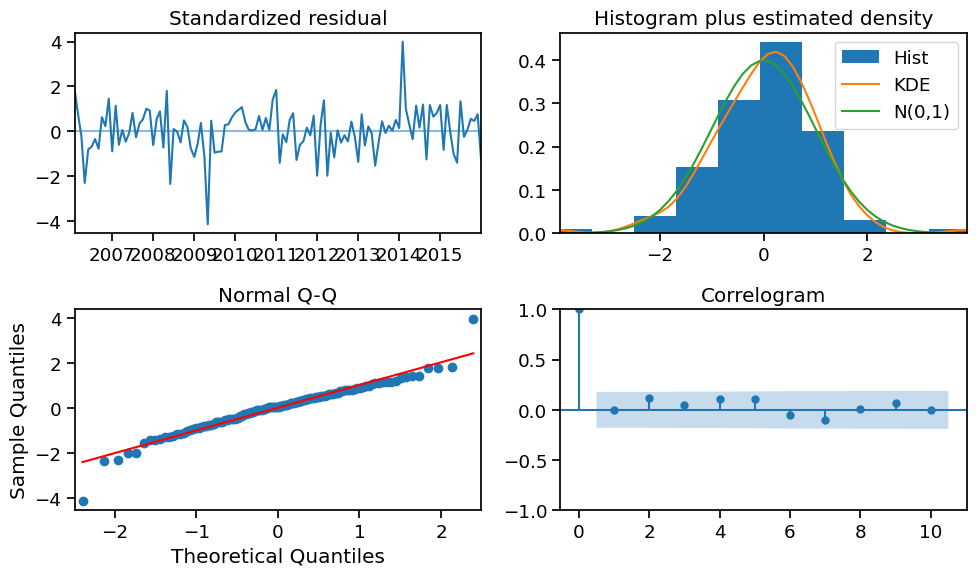

In [178]:
# Obtain diagnostic plots
fig = auto_model.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()



------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 32.589
- MSE = 1,880.939
- RMSE = 43.370
- R^2 = 0.675
- MAPE = 2.29%


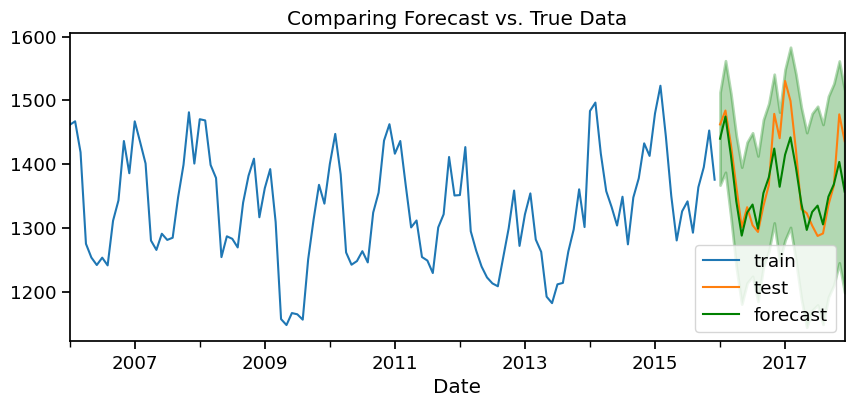

In [181]:
auto_modell = tsa.ARIMA(train , order= auto_model.order ,seasonal_order=auto_model.seasonal_order ).fit ()
forecast_model  =  auto_modell.get_forecast(steps=len(test)).summary_frame() 
plot_forecast(train , test , forecast_model)
regression_metrics_ts(test ,forecast_model['mean'])

# Based on the comparison of the metrics provided, the Auto-ARIMA model demonstrates the best overall performance:

* MAE (Mean Absolute Error) is the lowest at 32.589.
* MSE (Mean Squared Error) is the lowest at 1,880.939.
* RMSE (Root Mean Squared Error) is the lowest at 43.370.
* R² (Coefficient of Determination) is the highest at 0.675, indicating a better explanation of variance in the data.
* MAPE (Mean Absolute Percentage Error) is the lowest at 2.29%, indicating higher accuracy in predictions.
# Conclusion:
* The Auto-ARIMA model is the best model based on the given metrics, providing better accuracy and overall performance compared to the other models. This model can be used for time series forecasting with high confidence.






